In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Gradient Descent with Momentum

We want to create a method with two properties:

+ It should move through bad local minima with high probability.
+ It should eventually stop at a local minimum.

## Gradient descent in the limit of infinitesimal steps is a differential equation
Before we start, let's revisit gradient descent.
But think of the iterations as stepping through time.
Each iteration is a step forward in time by $\Delta t$ and also set the learning rate to $\alpha = \Delta t$.
We can write:

$$
x_{t+\Delta t} = x_t - \Delta t \nabla f(x_t).
$$

Rearranging the terms we get:

$$
\frac{x_{t+\Delta t} - x_t}{\Delta t} = - \nabla f(x_t).
$$

So, in the limit of infinitesimal steps, we get:

$$
\dot{x} = - \nabla f(x).
$$

Here the dot notation $\dot{x}$ is the time derivative of $x$.
We see that the parameters $x$ move by feeling a "force" $- \nabla f(x)$.

## Gradient descent with momentum

Okay, we saw that gradient descent is a differential equation.
It is as if the parameters $x$ are moving through time with a "force" $- \partial f(x)$. 
But I put the word "force" in quotes because it is not acting like a real force.
Where does a real force act?
Well, recall Newton's second law of motion:

$$
F = m \ddot{x}.
$$

So, we need a mass $m$ and an acceleration $\ddot{x}$.
But we only have a first order differential equation.

It doesn't matter. It is math. We can do whatever we want.
Let's promote the parameters to a particle with mass $m$.
Then we can write:

$$
m \ddot{x} = - \nabla f(x).
$$

The mass $m$ is a new parameter that we can set.
Now $-\nabla f(x)$ is a force that acts on the particle.

Okay, so far so good.
But we don't have exactly what we want.
Think about it for a moment.
The dynamics of the particle we just created are conservative.
So, the particle will oscillate may get out of a bad local minimum, but it will never stop. It will oscillate forever.

We need to add a dissipative force.
This can be done in many ways.
We are going to add a drag force that is proportional to the velocity of the particle.
So, think of the particle moving through a viscous fluid.
We can write:

$$
m \ddot{x} = - \nabla f(x) - \gamma \dot{x}.
$$

Now we have a particle that will move through bad local minima with high probability and eventually stop at a local minimum.
We also get another nice property.
If the particle finds itself in an flat region with low gradient, it will gradually accelerate until it reaches a final velocity.
This is nice because it will help the particle get out of a flat region.
The smaller the drag coefficient $\gamma$, the larger the final velocity, the faster the particle will move through flat regions.

Now, let's turn this into an algorithm.
The first step is to turn the differential equation to a first order dynamical system.

Define the momentum of the particle as:

$$
p = m\dot{x}.
$$

Then we can write:

$$
\begin{align*}
\dot{x} &= \frac{p}{m}, \\
\dot{p} &= - \nabla f(x) - \frac{\gamma}{m} p.
\end{align*}
$$

The second step is to discretize the dynamical system.
We can use the Euler method:

$$
\begin{align*}
x_{t+\Delta t} &= x_t + \Delta t \frac{p_t}{m}, \\
p_{t+\Delta t} &= p_t - \Delta t \left( \nabla f(x_t) + \frac{\gamma}{m} p_t \right) = \left(1 - \frac{\Delta t \gamma}{m}\right) p_t - \Delta t \nabla f(x_t).
\end{align*}
$$

Now we are ready to make the connection to the algorithm you see in the literature.
Define what they call the "velocity" by:

$$
v_t = \Delta t\frac{p_t}{m}.
$$

It is not a real velocity, of course. It is how much the parameters move in one iteration.

The update for the parameters becomes:

$$
x_{t+\Delta t} = x_t + v_t.
$$

The update for the "velocity" becomes:

$$
v_{t+\Delta t} = \left(1 - \frac{\Delta t \gamma}{m}\right) v_t - \frac{\Delta t^2}{m} \nabla f(x_t).
$$

Finally, write our *learning rate* as:

$$
\alpha = \frac{\Delta t^2}{m}.
$$

Write our *decay rate* as:

$$
\beta = \left(1 - \frac{\Delta t \gamma}{m}\right).
$$

The decay rate is between 0 and 1.
Typically, it is set to 0.9.
These are the parameters you see in the literature.

The final algorithm is:

$$
\begin{align*}
x_{t+1} &= x_t + v_{t+1},\\
v_{t+1} &= \beta v_t - \alpha \nabla f(x_t). \\
\end{align*}
$$

This is how the algorithm appeared in Ilya Sutskever's paper [On the importance of initialization and momentum in deep learning](http://www.cs.toronto.edu/~fritz/absps/momentum.pdf).

Let's implement this algorithm:

In [45]:
import jax.numpy as jnp 
from jax import grad, jit, vmap


def momentum(f, x0, v0=None, alpha=0.9, beta=0.9, n_iter=100, return_path=False):
    gf = jit(grad(f))
    x = x0
    v = v0 if v0 is not None else jnp.zeros_like(x0)
    path = [x]
    for i in range(n_iter):
        v = beta * v - alpha * gf(x)
        x += v
        path.append(x)
    if return_path:
        return x, path
    return x

Let's see how this works first on a 1D function.
We will start near the saddle point and see how the algorithm moves.

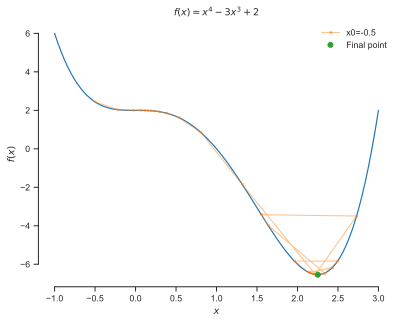

In [80]:
# The function to minimize
f1 = lambda x: x ** 4 - 3 * x ** 3 + 2

# Plot the function
xs = jnp.linspace(-1, 3, 100)
fig, ax = plt.subplots()
ax.plot(xs, f1(xs))
ax.set(xlabel='$x$', ylabel='$f(x)$', title='$f(x) = x^4 - 3x^3 + 2$')

# We will start near the saddle point
x0s = jnp.array([-0.5])

# The learning rate
alpha = 0.1
# The decay
beta = 0.5
n_iter = 100

for x0 in x0s:
    x, path = momentum(
        f1, x0, v0=0.0, n_iter=n_iter,
        alpha=alpha, beta=beta, return_path=True
    )
    f_path = vmap(f1)(jnp.array(path))
    ax.plot(path, f_path, '<-', markersize=2, linewidth=1, alpha=0.5, label=f'x0={x0}')
# Plot the final point
ax.plot(x, f1(x), 'o', markersize=5, label='Final point')
ax.legend(loc='best', frameon=False)
sns.despine(trim=True);

Observe two things:

+ The algorithm is not trapped at the saddle point.
+ The algorithm accelerates as it moves through the hill.
+ The algorithm oscillates and eventually stops at the minimum.

Here is another way to visualize the oscillations:

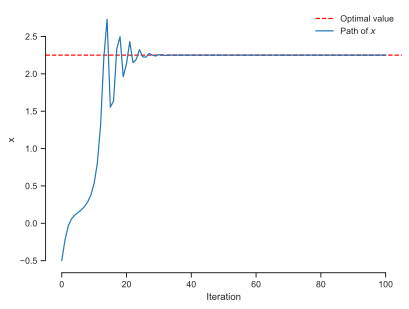

In [81]:
fig, ax = plt.subplots()
ax.axhline(9/4, linestyle='--', color='r', label='Optimal value')
ax.plot(path, label='Path of $x$')
ax.set(xlabel='Iteration', ylabel='x')
ax.legend(loc='best', frameon=False)
sns.despine(trim=True);

Experiment with different $\alpha$ and $\beta$ values to develop some intuition.
+ What happens if you set $\beta=0$?
+ What happens if you set $\beta=1$?
+ What happens if you start exactly on the saddle point $x=0$? You will notice that you get immediately trapped at the saddle point. Why is that? How can you fix it? Think of the parameters as a particle. You need to kick the particle out of the saddle point.

Let's also do it in 2D:

In [30]:
def plot_path(i, x_list):
    plt.quiver(x_list[:-1, 0], x_list[:-1, 1], x_list[1:, 0] - x_list[:-1, 0], x_list[1:, 1] - x_list[:-1, 1], 
               scale_units='xy', angles='xy', scale=1, color=plt.cm.tab10(i), width=0.004, headwidth=3, headlength=4)

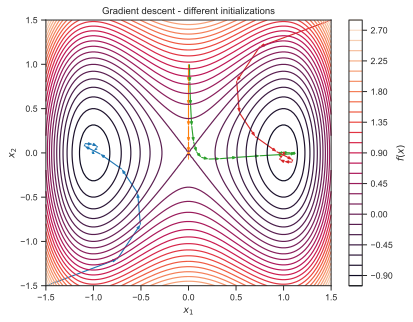

In [82]:
# The function to minimize
f = lambda x: x[0] ** 4 - 2.0 * x[0] ** 2 + x[1] ** 2
vf = vmap(f)
grad_f = jit(grad(f))

# The minimum
x_star = jnp.array([0.0, 0.0])

# The learning rate
alpha = 0.1
# The decay
beta = 0.5

# Plot 2D contour and path of optimization
x1s = jnp.linspace(-1.5, 1.5, 100)
x2s = jnp.linspace(-1.5, 1.5, 100)
X1, X2 = jnp.meshgrid(x1s, x2s)
X = jnp.vstack([X1.ravel(), X2.ravel()]).T
Z = vf(X).reshape(X1.shape)
c = plt.contour(X1, X2, Z, 30)
plt.colorbar(c, label='$f(x)$')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Gradient descent - different initializations')


# Run gradient descent
import jax.random as jrandom

key = jrandom.PRNGKey(1)

# Some initial points
x0s = jnp.array(
    [
        [-1.5, -1.5], 
        [0.0, 1.0],
        [0.01, 1.0],
        [1.5, 1.5]
    ]
)

for i, x0 in enumerate(x0s):
    key, subkey = jrandom.split(key)
    x_list = momentum(f, x0, 
        n_iter=100, alpha=alpha, beta=beta, 
        return_path=True
    )[1]
    x_list = jnp.stack(x_list, axis=0)
    plot_path(i, x_list)

Observe that the algorithm gets trapped at the saddle point when we start exactly above it.
Of course, this is unlikely to happen in practice when you randomly initialize the parameters.
But if we had given the algorithm a small initial velocity in a random direction, it would have escaped the saddle point.
Try it.

## Nestrov momentum

Illya Sutskever's paper [On the importance of initialization and momentum in deep learning](http://www.cs.toronto.edu/~fritz/absps/momentum.pdf) also introduced a variant of the momentum algorithm.
He was inspired by the work of [Yurii Nesterov](https://en.wikipedia.org/wiki/Yurii_Nesterov) on convex optimization.
The idea is to use the gradient at the next step instead of the current step.
The algorithm becomes:

$$
\begin{align*}
v_{t+1} &= \beta v_t - \alpha\nabla f(x_t + \beta v_t),\\
x_{t+1} &= x_t + v_{t+1}. \\
\end{align*}
$$

In words:

+ Use the current velocity to temporarily move the parameters. Observe that we don't use the learning rate, but we use the decay rate $\beta$ to move in the direction of the velocity.
It's like we are saying "let's see where we would be if we kept moving in the direction of the velocity" if we temporarily turned off the force $-\partial f(x)$.
+ Then, we compute the gradient at the temporary position.
+ We update the average velocity.
+ Finally, we update the parameters using the average velocity.

Let's implement this algorithm:

In [83]:
def nesterov(f, x0, v0=None, alpha=0.9, beta=0.9, n_iter=100, return_path=False):
    gf = jit(grad(f))
    x = x0
    v = v0 if v0 is not None else jnp.zeros_like(x0)
    path = [x]
    for i in range(n_iter):
        v = beta * v + alpha * gf(x - beta * v)
        x -= v
        path.append(x)
    if return_path:
        return x, path
    return x

Let's try it directly on the 2D function:

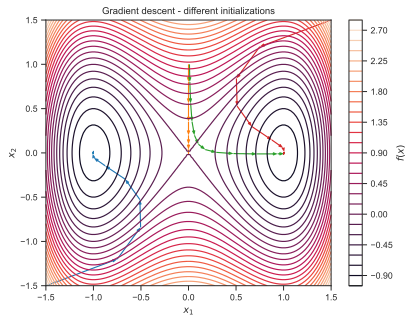

In [85]:
x1s = jnp.linspace(-1.5, 1.5, 100)
x2s = jnp.linspace(-1.5, 1.5, 100)
X1, X2 = jnp.meshgrid(x1s, x2s)
X = jnp.vstack([X1.ravel(), X2.ravel()]).T
Z = vf(X).reshape(X1.shape)
c = plt.contour(X1, X2, Z, 30)
plt.colorbar(c, label='$f(x)$')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Gradient descent - different initializations')

# The learning rate
alpha = 0.1
# The decay
beta = 0.5

for i, x0 in enumerate(x0s):
    key, subkey = jrandom.split(key)
    x_list = nesterov(f, x0, 
        n_iter=100, alpha=alpha, beta=beta, 
        return_path=True
    )[1]
    x_list = jnp.stack(x_list, axis=0)
    plot_path(i, x_list)    

Observe that the oscillations have been ironed out.